In [1]:
import sys
from pathlib import Path

# Get the root directory of the project
project_root = Path("/home/lxz/scmamba/KCellFM_tutorial/cell_cycle_classification").parent.parent
# project_root = Path(__file__).parent.parent
sys.path.append(str(project_root))

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import pandas as pd
import numpy as np
from models.model import MambaModel
from models.gene_tokenizer import GeneVocab
from sklearn.model_selection import train_test_split
import anndata
import random
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt

/home/lxz/tools/anaconda3/envs/scgpt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Fixed random seeds ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  

In [4]:
# configuration parameters
epochs = 50  # 50 epochs
batch_size = 64
embsize = 512
nhead = 8
d_hid = 512
nlayers = 6
dropout = 0.1
lr = 1e-5
pad_token = "<pad>"
max_seq_len = 8192
input_emb_style = "continuous"
cell_emb_style = "cls"
mask_value = -1
pad_value = -2

In [5]:
# Load vocabulary list
vocab = GeneVocab.from_file("/home/lxz/scmamba/vocab.json")
ntokens = len(vocab)

In [6]:
# Category Mapping
label_to_id = {
    'single H1-Fucci cell sorted from G1 phase of the cell cycle only': 0,
    'single H1-Fucci cell sorted from S phase of the cell cycle only': 1,
    'single H1-Fucci cell sorted from G2/M phase of the cell cycle only': 2
}
class_num = len(label_to_id)

In [7]:
class CellCycleDataset(Dataset):
    def __init__(self, expr_matrix, labels):
        self.expr_matrix = expr_matrix
        self.labels = labels
        self.cell_ids = list(labels.index)
        
    def __len__(self):
        return len(self.cell_ids)
    
    def __getitem__(self, idx):
        cell_id = self.cell_ids[idx]
        # Obtain gene expression data
        expr_values = self.expr_matrix.loc[cell_id].values  # Ensure continuous memory
        gene_names = self.expr_matrix.columns
        
        # Only retain genes with non-zero expression values
        non_zero_indices = np.where(expr_values != 0)[0]
        expr_values = expr_values[non_zero_indices]
        gene_names = gene_names[non_zero_indices]

        # Map gene names to IDs and filter expression values simultaneously
        filtered_gene_ids = []
        filtered_expr_values = []
        for gene, value in zip(gene_names, expr_values):
            if gene in vocab:  # Only keep genes in the vocabulary list
                filtered_gene_ids.append(vocab[gene])
                filtered_expr_values.append(value)
        gene_ids = filtered_gene_ids
        expr_values = filtered_expr_values
        
        # Add CLS token
        if len(gene_ids) > max_seq_len:
            idx = np.random.choice(len(gene_ids), max_seq_len, replace=False)
            gene_ids = [gene_ids[i] for i in idx]
            expr_values = [expr_values[i] for i in idx]
             
        # Fill sequence
        padding_length = max_seq_len - len(gene_ids)
        if padding_length > 0:
            gene_ids = gene_ids + [vocab["<pad>"]] * padding_length
            expr_values = expr_values + [pad_value] * padding_length
        gene_ids = [vocab["<cls>"]] + gene_ids
        expr_values = np.concatenate([[0.0], expr_values]) 
        
        # Create padding mask
        padding_mask = [False] * (max_seq_len+1)
        for i in range(len(padding_mask)):
            if gene_ids[i] == vocab["<pad>"]:
                padding_mask[i] = True
        
        # Get tags
        label = label_to_id[self.labels[cell_id]]
        return {
            'gene_ids': torch.LongTensor(gene_ids),
            'expr_values': torch.FloatTensor(expr_values),
            'padding_mask': torch.BoolTensor(padding_mask),
            'label': torch.as_tensor(label, dtype=torch.long)
        }

In [8]:
def train():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # load dataset
    expr_matrix = pd.read_csv("/home/lxz/scmamba/细胞周期/h-ESC/GSE64016_logp_10k.csv", index_col=0)
    adata = anndata.read_h5ad("/home/lxz/scmamba/细胞周期/GSE64016_adata.h5ad")
    expr_matrix.index = adata.obs.index
    labels = pd.Series(adata.obs['source_name_ch1'], index=adata.obs.index)
    mask = labels != 'single H1 hESC'
    filtered_expr_matrix = expr_matrix[mask]
    filtered_labels = labels[mask]

    # Divide the training and test set
    train_idx, test_idx = train_test_split(
        np.arange(len(filtered_labels)),
        test_size=0.3,
        stratify=filtered_labels,
        random_state=42
    )
    
    # Create dataset
    full_dataset = CellCycleDataset(filtered_expr_matrix, filtered_labels)
    train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
    test_dataset = torch.utils.data.Subset(full_dataset, test_idx)
    
    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # Initialize model
    model = MambaModel(
        ntokens, embsize, nhead, d_hid, nlayers,
        vocab=vocab, dropout=dropout, pad_token=pad_token,
        pad_value=pad_value, input_emb_style=input_emb_style,
        cell_emb_style=cell_emb_style, class_num=class_num
    ).to(device)

    # Load pre-trained weights (skip classification header)
    try:
        pretrained_dict = torch.load("/home/lxz/scmamba/model_state/cell_cls_3loss_6layer_final.pth",
                                    map_location=device)
        model_dict = model.state_dict()

        pretrained_dict = {k: v for k, v in pretrained_dict.items()
                        if k in model_dict and v.shape == model_dict[k].shape
                        and not k.startswith('cls_decoder')}  # Exclude all category header parameters

        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        print("Successfully loaded pre training weights (excluding classification head weights)")

        # Reinitialize the classification header
        print("Initialize the classification header weights...")
        nn.init.kaiming_normal_(model.cls_decoder.out_layer.weight, mode='fan_in', nonlinearity='relu')
        if model.cls_decoder.out_layer.bias is not None:
            nn.init.zeros_(model.cls_decoder.out_layer.bias)
    except Exception as e:
        print(f"Failed to load pre-training weights: {str(e)}")

    # Freeze and unfreeze logic
    print(f"Freeze the first {nlayers - 3} layer, unfreeze the last 3 layers and classifier")

    # First, freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last two layers of Mamba layer
    for i in range(nlayers - 3, nlayers):
        layer = model.mamba_encoder[i]
        for param in layer.parameters():
            param.requires_grad = True
        print(f"Unfreeze Mamba layers {i}: Parameters trainable")

    # Unfreeze classification header
    for param in model.cls_decoder.parameters():
        param.requires_grad = True
    print("The classifier parameters have been set to trainable")

    # Print trainable parameters
    print("\nTrainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

    # Only optimize the parameters that need to be trained
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    print(f"\nNumber of trainable parameters: {sum(p.numel() for p in trainable_params)}")

    # Optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    # Record the training process
    test_accuracies = []
    train_losses = []
    
    # training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            gene_ids = batch['gene_ids'].to(device)
            expr_values = batch['expr_values'].to(device)
            padding_mask = batch['padding_mask'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(
                    src=gene_ids,
                    values=expr_values,
                    src_key_padding_mask=padding_mask
                )
            loss = criterion(outputs["cls_output"], labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        
        # Record training loss
        epoch_loss = total_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Test set evaluation
        model.eval()
        test_preds, test_labels = [], []
        all_cell_embs = []
        with torch.no_grad():
            for batch in test_loader:
                gene_ids = batch['gene_ids'].to(device)
                expr_values = batch['expr_values'].to(device)
                padding_mask = batch['padding_mask'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(src=gene_ids, values=expr_values, src_key_padding_mask=padding_mask)
                _, predicted = torch.max(outputs["cls_output"], 1)
                cell_embs = outputs["cell_emb"].cpu().numpy()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
                all_cell_embs.append(cell_embs)
        
        test_accuracy = 100 * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
        test_accuracies.append(test_accuracy)
        all_cell_embs = np.concatenate(all_cell_embs, axis=0)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")
    
    # Save model and results
    torch.save(model.state_dict(), '/home/lxz/scmamba/model_state/mamba_cell_cycle_final_ipynb.pth')
    np.save("/home/lxz/scmamba/细胞周期/cell_embeddings_test.npy", all_cell_embs)
    
    predictions = {
        'preds': test_preds,
        'labels': test_labels,
    }
    
    with open('/home/lxz/scmamba/细胞周期/labels_preds_test.pkl', 'wb') as f:
        pickle.dump(predictions, f)
    
    # Draw training curve
    plt.figure(figsize=(12, 5))
    
    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), test_accuracies, 'b-o', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy vs. Epoch')
    plt.xticks(np.arange(1, epochs+1, step=max(1, epochs//10)))
    plt.grid(True)
    plt.legend()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_losses, 'r-o', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Epoch')
    plt.xticks(np.arange(1, epochs+1, step=max(1, epochs//10)))
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('/home/lxz/scmamba/细胞周期/training_curve_ipynb.png', dpi=300)
    plt.show()
    
    
    # Output the final result
    print("\n===== Final Test Results =====")
    print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
    print(classification_report(
        test_labels,
        test_preds,
        target_names=list(label_to_id.keys()),
        digits=4
    ))

Successfully loaded pre training weights (excluding classification head weights)
Initialize the classification header weights...
Freeze the first 3 layer, unfreeze the last 3 layers and classifier
Unfreeze Mamba layers 3: Parameters trainable
Unfreeze Mamba layers 4: Parameters trainable
Unfreeze Mamba layers 5: Parameters trainable
The classifier parameters have been set to trainable

Trainable parameters:
cls_decoder._decoder.0.weight
cls_decoder._decoder.0.bias
cls_decoder._decoder.2.weight
cls_decoder._decoder.2.bias
cls_decoder._decoder.3.weight
cls_decoder._decoder.3.bias
cls_decoder._decoder.5.weight
cls_decoder._decoder.5.bias
cls_decoder.out_layer.weight
cls_decoder.out_layer.bias
mamba_encoder.3.mamba_fwd.dt_bias
mamba_encoder.3.mamba_fwd.A_log
mamba_encoder.3.mamba_fwd.D
mamba_encoder.3.mamba_fwd.in_proj.weight
mamba_encoder.3.mamba_fwd.conv1d.weight
mamba_encoder.3.mamba_fwd.conv1d.bias
mamba_encoder.3.mamba_fwd.norm.weight
mamba_encoder.3.mamba_fwd.out_proj.weight
mamba_en

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.93s/it, loss=1.56]


Epoch 1/50 - Loss: 1.9089 - Test Accuracy: 34.67%


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.96s/it, loss=1.46]


Epoch 2/50 - Loss: 1.5332 - Test Accuracy: 40.00%


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it, loss=1.28]


Epoch 3/50 - Loss: 1.3079 - Test Accuracy: 40.00%


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it, loss=1.18]


Epoch 4/50 - Loss: 1.1800 - Test Accuracy: 33.33%


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.08]


Epoch 5/50 - Loss: 1.1455 - Test Accuracy: 34.67%


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.09]


Epoch 6/50 - Loss: 1.1481 - Test Accuracy: 37.33%


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.18]


Epoch 7/50 - Loss: 1.1572 - Test Accuracy: 37.33%


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it, loss=1.2]


Epoch 8/50 - Loss: 1.1709 - Test Accuracy: 32.00%


Epoch 9/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.946]


Epoch 9/50 - Loss: 1.0335 - Test Accuracy: 38.67%


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it, loss=1.12]


Epoch 10/50 - Loss: 1.1016 - Test Accuracy: 44.00%


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.01]


Epoch 11/50 - Loss: 1.0472 - Test Accuracy: 42.67%


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.14]


Epoch 12/50 - Loss: 1.1094 - Test Accuracy: 38.67%


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.04]


Epoch 13/50 - Loss: 1.0615 - Test Accuracy: 45.33%


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it, loss=1.13]


Epoch 14/50 - Loss: 1.0967 - Test Accuracy: 45.33%


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.08]


Epoch 15/50 - Loss: 1.0322 - Test Accuracy: 40.00%


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.08]


Epoch 16/50 - Loss: 1.0583 - Test Accuracy: 40.00%


Epoch 17/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1]


Epoch 17/50 - Loss: 1.0361 - Test Accuracy: 34.67%


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it, loss=1.01]


Epoch 18/50 - Loss: 1.0127 - Test Accuracy: 50.67%


Epoch 19/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.959]


Epoch 19/50 - Loss: 1.0314 - Test Accuracy: 34.67%


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.02]


Epoch 20/50 - Loss: 1.0309 - Test Accuracy: 40.00%


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it, loss=1.12]


Epoch 21/50 - Loss: 1.0439 - Test Accuracy: 42.67%


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.08]


Epoch 22/50 - Loss: 1.0319 - Test Accuracy: 48.00%


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.12]


Epoch 23/50 - Loss: 1.0470 - Test Accuracy: 42.67%


Epoch 24/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.948]


Epoch 24/50 - Loss: 1.0024 - Test Accuracy: 44.00%


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.04]


Epoch 25/50 - Loss: 1.0410 - Test Accuracy: 46.67%


Epoch 26/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.938]


Epoch 26/50 - Loss: 0.9688 - Test Accuracy: 42.67%


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.06]


Epoch 27/50 - Loss: 1.0641 - Test Accuracy: 48.00%


Epoch 28/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.931]


Epoch 28/50 - Loss: 0.9704 - Test Accuracy: 53.33%


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it, loss=1.02]


Epoch 29/50 - Loss: 0.9915 - Test Accuracy: 44.00%


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.02]


Epoch 30/50 - Loss: 1.0094 - Test Accuracy: 48.00%


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.02]


Epoch 31/50 - Loss: 1.0273 - Test Accuracy: 53.33%


Epoch 32/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it, loss=0.979]


Epoch 32/50 - Loss: 0.9878 - Test Accuracy: 50.67%


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it, loss=1.1]


Epoch 33/50 - Loss: 1.0514 - Test Accuracy: 52.00%


Epoch 34/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.999]


Epoch 34/50 - Loss: 1.0252 - Test Accuracy: 46.67%


Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.975]


Epoch 35/50 - Loss: 0.9899 - Test Accuracy: 42.67%


Epoch 36/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.892]


Epoch 36/50 - Loss: 0.9961 - Test Accuracy: 53.33%


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.05]


Epoch 37/50 - Loss: 1.0218 - Test Accuracy: 44.00%


Epoch 38/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.941]


Epoch 38/50 - Loss: 0.9779 - Test Accuracy: 48.00%


Epoch 39/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it, loss=0.952]


Epoch 39/50 - Loss: 0.9759 - Test Accuracy: 46.67%


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=1.13]


Epoch 40/50 - Loss: 1.0592 - Test Accuracy: 46.67%


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it, loss=1.04]


Epoch 41/50 - Loss: 0.9795 - Test Accuracy: 48.00%


Epoch 42/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.908]


Epoch 42/50 - Loss: 0.9274 - Test Accuracy: 52.00%


Epoch 43/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.968]


Epoch 43/50 - Loss: 0.9699 - Test Accuracy: 45.33%


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it, loss=1.03]


Epoch 44/50 - Loss: 1.0072 - Test Accuracy: 48.00%


Epoch 45/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.979]


Epoch 45/50 - Loss: 0.9627 - Test Accuracy: 54.67%


Epoch 46/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.937]


Epoch 46/50 - Loss: 0.9515 - Test Accuracy: 50.67%


Epoch 47/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.897]


Epoch 47/50 - Loss: 0.9639 - Test Accuracy: 54.67%


Epoch 48/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it, loss=0.934]


Epoch 48/50 - Loss: 0.9372 - Test Accuracy: 45.33%


Epoch 49/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.949]


Epoch 49/50 - Loss: 1.0137 - Test Accuracy: 50.67%


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it, loss=0.81]


Epoch 50/50 - Loss: 0.9299 - Test Accuracy: 44.00%


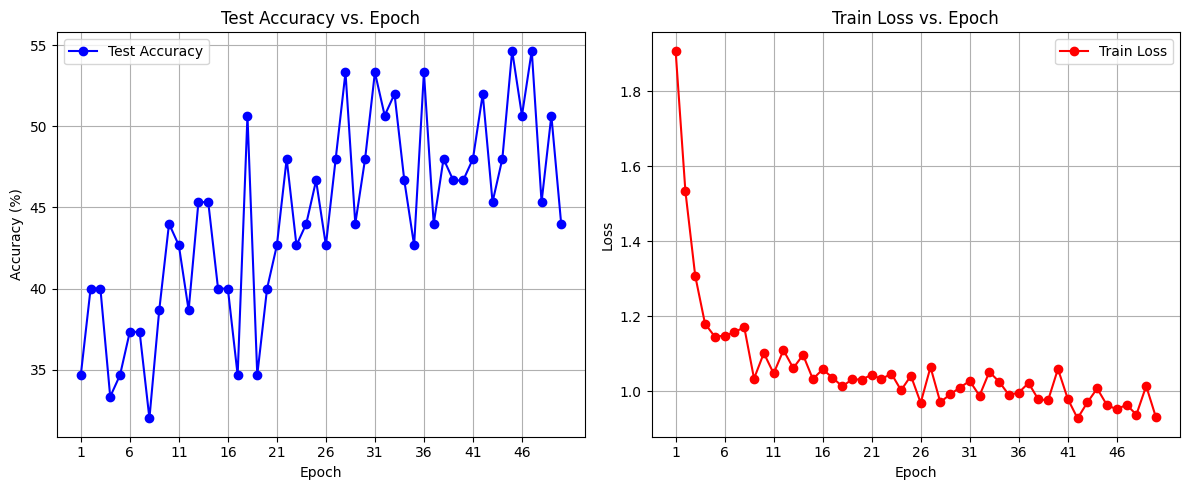


===== Final Test Results =====
Final Test Accuracy: 44.00%
                                                                    precision    recall  f1-score   support

  single H1-Fucci cell sorted from G1 phase of the cell cycle only     0.4400    0.3929    0.4151        28
   single H1-Fucci cell sorted from S phase of the cell cycle only     0.4194    0.5417    0.4727        24
single H1-Fucci cell sorted from G2/M phase of the cell cycle only     0.4737    0.3913    0.4286        23

                                                          accuracy                         0.4400        75
                                                         macro avg     0.4443    0.4419    0.4388        75
                                                      weighted avg     0.4437    0.4400    0.4377        75



In [9]:
if __name__ == "__main__":
    train()